<a name="top"> <h1>02. Neuronal Networks</h1> <a>

<p>Análisis de sentimiento: Tweets<br />
<strong>Trabajo de Fin de Master</strong><br />
<strong>Master Universitario en Ciencia de Datos</strong></p>


<p style="text-align:right">V&iacute;ctor Viloria V&aacute;zquez (<em>victor.viloria@cunef.edu</em>)</p>


<hr style="border:1px solid gray">

### Estructura

[Introducción](#introduccion) 

[1. Librerias utilizadas y funciones](#librerias) 

[2. Lectura del dataframe y preparación de los datos](#lectura) 

   - 2.1. Lectura del DF
   - 2.2. Preparación de los datos

[3. Modelo de la red neuronal](#modelo) 

[4. Backup del modelo](#backup) 

<hr style="border:1px solid gray">

# <a name="introduccion"> Introducción <a>


En este tercer notebook, tras haber preprocesado los datos y evaluado diferentes modelos de Machine Learning, exploraremos las redes neuronales con el objetivo de superar los resultados obtenidos en `1_MLModels`

Para ello nos ayudaremos principalmente de la libreria TensorFlow, la cual nos permite de una forma secilla, crear arquitecutras de redes neuronales y modificar los hiperparámetros para ajustar el modelo, además de introducir técnicas de regularización.

Una vez obtengamos los resultados y seleccionemos aquel que mejor resultado haya arrojado, procederemos a seleccionarlo ya sea de ML o DL, para ponerlo en producción.

# <a name="librerias"> 1. Librerias utilizadas y funciones <a>


Importamos las librerias a utilizar para la creación de redes neuronales:

In [1]:
# Import basic libraries.

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
import numpy as np
import string
import pickle

# Import neural network libraries.

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score

# <a name="lectura"> 2. Lectura del dataframe y preparación de los datos<a>


## 2.1. Lectura del DF

In [2]:
#Import parquet file.

reviews = pd.read_parquet('../../data/processed/reviews.parquet')

# Show the head of the dataframe.

reviews.head()

,reviewText,overall
0,amazon shopping amazoncom gift cards christmas...,1
1,got gift card friend best site much choose gre...,5
2,arent going save trees people complaining pape...,5
3,always get someone something amazon safety net...,5
4,take 50 dollars good money limitations turn am...,1


## 2.2. Preparación de los datos

Al igual que en el notebook anterior, preparamos los datos para que puedan ser introducidos dentro de los modelos, separando en X el texto y en y las puntuaciones. Y modificando el formato para que puedan ser introducidos dentro de la red.

In [15]:
# Define the X and y variables.

X = reviews['reviewText'].values
y = reviews['overall'].values

# Modify the y variable to be a categorical variable.

y = tf.keras.utils.to_categorical(y-1, num_classes=5)

# Split the data into train and test sets.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Define the tokenizer.

tokenizer = Tokenizer(num_words=10000)

# Fit the tokenizer.

tokenizer.fit_on_texts(X_train)

# Transform the train and test sets.

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Add padding to the train and test sets.

vocab_size = len(tokenizer.word_index) + 1

maxlen = 300

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)



In [4]:
# Dividir los datos en características y etiquetas
X = reviews['reviewText'].values
y = reviews['overall'].values
y = tf.keras.utils.to_categorical(y)  # Convertir los valores numéricos a representación categórica (one-hot encoding)

# División de datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenización y secuenciación del texto
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Save the tokenizer.

with open('../../models/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Ajuste de la longitud de las secuencias (padding)
max_sequence_length = 500  # Longitud máxima de una secuencia de palabras
X_train_seq = tf.keras.preprocessing.sequence.pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_seq = tf.keras.preprocessing.sequence.pad_sequences(X_test_seq, maxlen=max_sequence_length)




In [16]:
# Save the tokenizer in models.

with open('../../models/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


# <a name="modelo"> 3. Modelo de la red neuronal<a>

Tras hacer diferentes pruebas fuera del notebook, ponemos a prueba el que mejor resultado nos ha dado:

In [5]:
# Define the model.

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=128, input_length=300),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(5, activation='softmax')
])

# Compile the model.

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
# Structure of the model.

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 300, 128)          1280000   
                                                                 
 dropout_2 (Dropout)         (None, 300, 128)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 300, 32)           12320     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 150, 32)          0         
 1D)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 64)                24832     
                                                                 
 dense_4 (Dense)             (None, 5)                 325       
                                                      

In [19]:
# Fit the model.

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128)

Epoch 1/10
761/761 [==============================] - 98s 127ms/step - loss: 0.6334 - accuracy: 0.8440 - val_loss: 0.6221 - val_accuracy: 0.8473
Epoch 2/10
761/761 [==============================] - 95s 125ms/step - loss: 0.6226 - accuracy: 0.8451 - val_loss: 0.6154 - val_accuracy: 0.8473
Epoch 3/10
761/761 [==============================] - 114s 149ms/step - loss: 0.6223 - accuracy: 0.8451 - val_loss: 0.6156 - val_accuracy: 0.8473
Epoch 4/10
761/761 [==============================] - 115s 151ms/step - loss: 0.6222 - accuracy: 0.8451 - val_loss: 0.6155 - val_accuracy: 0.8473
Epoch 5/10
761/761 [==============================] - 111s 145ms/step - loss: 0.6220 - accuracy: 0.8451 - val_loss: 0.6159 - val_accuracy: 0.8473
Epoch 6/10
761/761 [==============================] - 93s 122ms/step - loss: 0.6220 - accuracy: 0.8451 - val_loss: 0.6160 - val_accuracy: 0.8473
Epoch 7/10
761/761 [==============================] - 97s 128ms/step - loss: 0.6218 - accuracy: 0.8451 - val_loss: 0.6153 - val

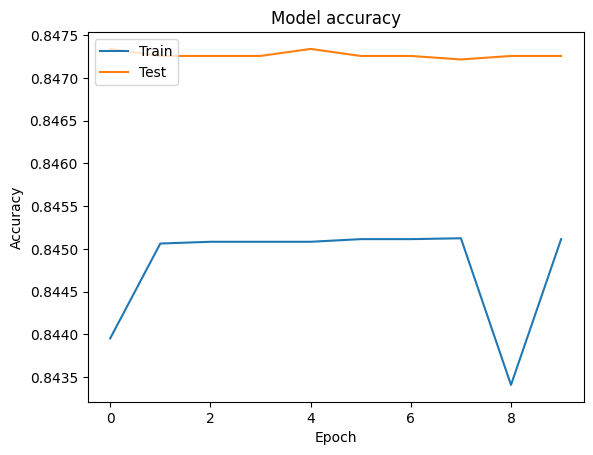

In [20]:
# Creat a graph with number of epochs and accuracy in the train and test sets.

import matplotlib.pyplot as plt

plt.plot(model.history.history['accuracy'])

plt.plot(model.history.history['val_accuracy'])

plt.title('Model accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epoch')

plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [21]:
# F2 score

fbeta_score(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1), average='micro', beta=2)

761/761 [==============================] - 10s 12ms/step


0.8472564481682273

# <a name="backup"> 4. Backup del modelo<a>

Dado que es el modelo que mejor resultado nos ha dado, procedemos a guardarlo para posteriormente ponerlo en producción.

In [22]:
# Guardar el modelo en un archivo
model.save("../../models/nn_reviews.h5")

In [24]:
# Load the model.

model = tf.keras.models.load_model('../../models/nn_reviews.h5', compile=False)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Load the tokenizer that trained the Neuronal Network.

with open('../../models/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Predict the class of the review.

input_text = "Horrible"

# Convert the text to sequence of words

X_test_sequences = tokenizer.texts_to_sequences([input_text])

# Pad the sequence

X_test_padded = pad_sequences(X_test_sequences, maxlen=len(X_test_sequences), padding='post')

# Make predictions

predictions = model.predict(X_test_padded)

# Get the sentiment with the highest probability

sentiment = np.argmax(predictions)

sentiment

ValueError: in user code:

    File "c:\Users\e107816\AppData\Local\miniconda3\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\e107816\AppData\Local\miniconda3\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\e107816\AppData\Local\miniconda3\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\e107816\AppData\Local\miniconda3\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\e107816\AppData\Local\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\e107816\AppData\Local\miniconda3\lib\site-packages\keras\backend.py", line 6493, in pool2d
        x = tf.compat.v1.nn.max_pool(

    ValueError: Exception encountered when calling layer "max_pooling1d_2" "                 f"(type MaxPooling1D).
    
    Negative dimension size caused by subtracting 2 from 1 for '{{node sequential_3/max_pooling1d_2/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 1, 1], padding="VALID", strides=[1, 2, 1, 1]](sequential_3/max_pooling1d_2/ExpandDims)' with input shapes: [?,1,1,32].
    
    Call arguments received by layer "max_pooling1d_2" "                 f"(type MaxPooling1D):
      • inputs=tf.Tensor(shape=(None, 1, 32), dtype=float32)
